## Dependencies

In [15]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
import os
import numpy as np
from ipynb.fs.full.Dataset_Construction_Isolated import construct_dataset
import matplotlib.pyplot as plt
import matplotlib.image as plt_img

import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import datetime

from zipfile import ZipFile 

## Parameters

In [17]:
name = "TestCNN"
epochs = 5
steps = 50
batch = 40

## Making directory for CNN

In [19]:
try:
    os.mkdir("CNN/" + name)
except:
    pass

try:
    os.mkdir("CNN/" + name + "/Tensorboard_Data")
except:
    pass

## Load constructed dataset

In [20]:
lst = os.listdir() 
if ("mushroom_dataset_x.npy" not in lst) or ("mushroom_dataset_y.npy" not in lst):
    print("Dataset files not found, contructing...")
    dataset_x, dataset_y = construct_dataset()
else:
    print("Dataset files found, loading...")
    dataset_x = np.load("mushroom_dataset_x.npy")
    dataset_y = np.load("mushroom_dataset_y.npy")
    print("Done")

Dataset files found, loading...
Done


## CNN Training

In [21]:
cnn = models.Sequential([
    tf.keras.Input(shape=(227, 227, 3), batch_size=batch),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

cnn.compile(optimizer="adam", loss="binary_crossentropy",  metrics=["accuracy"])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='batch')

In [22]:
history = cnn.fit(dataset_x, 
                  dataset_y, validation_split=0.1, epochs=epochs, steps_per_epoch=steps, callbacks=[tensorboard_callback])

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 410ms/step - accuracy: 0.8024 - loss: 0.6324 - val_accuracy: 0.0000e+00 - val_loss: 1.3666
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.8246 - loss: 0.3487 - val_accuracy: 0.0100 - val_loss: 1.9412
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 394ms/step - accuracy: 0.8538 - loss: 0.2889 - val_accuracy: 0.0750 - val_loss: 1.4927
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 393ms/step - accuracy: 0.9113 - loss: 0.2265 - val_accuracy: 0.0800 - val_loss: 2.0317
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - accuracy: 0.9530 - loss: 0.1364 - val_accuracy: 0.2800 - val_loss: 2.5194


## Open Tensorboard

In [ ]:
%tensorboard --logdir="logs/" --host=127.0.0.1 

## CNN Evaluation

### Load final dataset

In [30]:
if "FinalTrainTestSet" not in os.listdir():
        print("Unzipping final dataset...")
        with ZipFile("FinalTrainTestSet.zip", 'r') as zObject: 
            zObject.extractall(path="FinalTrainTestSet")
        print("Done")
        
print("Loading train_x...")
ftrain_x = np.load("FinalTrainTestSet/train_x.npy")
print("Done")

print("Loading train_y...")
ftrain_y = np.load("FinalTrainTestSet/train_y.npy")
print("Done")

print("Loading test_x...")
ftest_x = np.load("FinalTrainTestSet/test_x.npy")
print("Done")

print("Loading test_y...")
ftest_y = np.load("FinalTrainTestSet/test_y.npy")
print("Done")

Loading train_x...
Done
Loading train_y...
Done
Loading test_x...
Done
Loading test_y...
Done


## Train model

In [ ]:
cnn = models.Sequential([
    tf.keras.Input(shape=(227, 227, 3), batch_size=batch),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

log_dir = "logs/fit/" + name + "Final"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch')

cnn.compile(optimizer="adam", loss="binary_crossentropy",  metrics=["accuracy"])
cnn.fit(ftrain_x, ftrain_y, epochs=epochs, steps_per_epoch=steps, callbacks=[tensorboard_callback])

#cnn.save("CNN/" + name + "/" + name + ".keras")

## Open Tensorboard for train time

In [ ]:
%tensorboard --logdir="logs/" --host=127.0.0.1 

## Generate prediction set

In [40]:
pred_y = np.empty([200, 1])
meta = np.empty([1, 227, 227, 3])

for i in range(0, ftest_x.shape[0]):
    meta[0] = ftest_x[i]
    pred_value = cnn.predict(meta, verbose=0)[0][0]
    
    if pred_value > 0.5:
        pred = 1
    else:
        pred = 0
        
    pred_y[i] = pred

## Graph confusion matrix

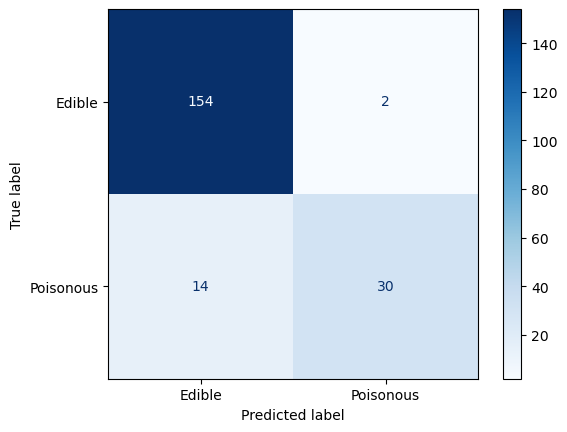

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(ftest_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=["Edible", "Poisonous"])
disp.plot(cmap=plt.cm.Blues).figure_.savefig("CNN/" + name + "/" + name + "_ConfustionMatrix.svg")

## CNN Metrics

In [58]:
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]

accuracy = (tp + tn) / (tp + tn + fn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (precision *  recall) / (precision + recall)
f1 *= 2

print(name + ":")
print("Accuracy  {:0.2f} %".format(accuracy * 100))
print("Precision {:0.2f} %".format(precision * 100))
print("Recall    {:0.2f} %".format(recall * 100))
print("F1        {:0.2f} %".format(f1 * 100))

TestCNN:
Accuracy  92.00 %
Precision 98.72 %
Recall    91.67 %
F1        95.06 %
